In [1]:
import pyvacon
import datetime as dt
import math

import pyvacon.marketdata.testdata as mkt_testdata
import pyvacon.tools.enums as enums
import pyvacon.marketdata.plot as mkt_plot
import pyvacon.models.plot as model_plot
import pyvacon.models.tools as model_tools

import pyvacon.analytics as analytics
import pyvacon.tools.converter as converter


import matplotlib.pyplot as plt
%matplotlib inline


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.transforms as mtransforms
%matplotlib inline
import numpy as np

import pandas as pd

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

C:\Users\Anwender\.conda\envs\python36\lib\site-packages\pyvacon\__init__.py:10: UserWarning: Imported pyvacon is just beta version.
  warnings.warn('Imported pyvacon is just beta version.')


# Generate Scenarios

In [2]:
# load test data from an Excel file
xl = pd.ExcelFile('TestDaten.xlsx')
#print(xl.sheet_names)

In [3]:
dfEONIA = xl.parse('EONIA')
dfEONIA = pd.DataFrame(dfEONIA,
                       columns = [
                           'stichtag6',
                           'prz_bs1j',
                           'prz_bs2j',
                           'prz_bs3j',
                           'prz_bs4j',
                           'prz_bs5j',
                           'prz_bs6j',
                           'prz_bs7j',
                           'prz_bs8j',
                           'prz_bs9j',
                           'prz_bs10j'
                       ])

# convert Excel dates to a human-readable format and add them to the data frame as a new column
dfEONIA['datum'] = pd.TimedeltaIndex(dfEONIA['stichtag6'], unit='d') + dt.datetime(1899, 12, 30)
#print(dfEONIA)

In [4]:
# absolute Differenzen berechnen
timeinterval = 1 # number of business days (TARGET2), i.e. the number of rows in the Excel sheet

# restrict to certain columns
dfDiffs = pd.DataFrame(dfEONIA,
                       columns = [
                           'prz_bs1j',
                           'prz_bs2j',
                           'prz_bs3j',
                           'prz_bs4j',
                           'prz_bs5j',
                           'prz_bs6j',
                           'prz_bs7j',
                           'prz_bs8j',
                           'prz_bs9j',
                           'prz_bs10j'
                       ])
#print(dfDiffs)

# save the current market data in a pandas.series
sCurrent = dfDiffs.iloc[0,:]
#print(sCurrent)

# Compute the elementwise difference (diff) of rows in the data frame (DF)
# diff[i] = DF[i]-DF[i-n]
# In words: For n = 1 we subtract from the values of any given row the values of the preceeding row
dfDiffs = dfDiffs.diff(periods=timeinterval)
#print(dfDiffs)

# Since we want
# diff[i] = DF[i-n]-DF[i], so that DF[i]+diff[i] = DF[i-n],
# we need to multiply by -1
dfDiffs = dfDiffs * (-1)
#print(dfDiffs)

# Get rid of the NaN rows
dfDiffs = dfDiffs.iloc[timeinterval:, :]
#print(dfDiffs)

# Compute the scenarios by adding the diffs to the current market data
dfScenarios = dfDiffs + sCurrent
#print(dfScenarios)
#print(sCurrent)
#print(dfDiffs.iloc[71,:])
#print(dfScenarios.iloc[71,:])

# Define a Portfolio
Start with one simple bond.

In [5]:
# define the reference date as the date of the first market data sample (rows are ordered by date desc)
refdate = dt.datetime(year = dfEONIA.iloc[0]['datum'].year, month = dfEONIA.iloc[0]['datum'].month, day = dfEONIA.iloc[0]['datum'].day)

duration = 10
maturity = dt.datetime(year = refdate.year + duration, month = refdate.month, day = refdate.day)
#print(refdate)
#print(maturity)

# Generate the coupon payment schedule as a vector of datetimes
coupon_dates = []
for i in range(duration):
    coupon_dates.append(dt.datetime(year = refdate.year + i + 1, month = refdate.month, day = refdate.day))
#print(coupon_dates)

# We now use these dates to define a fixed coupon bond
principal = 100.0
coupon_rates = [0.05]*len(coupon_dates)
coupon_payments = [0.05*principal]*len(coupon_dates)

fixed_coupon_bond = pyvacon.instruments.BondSpecification('Fixed_Coupon', 'DBK', enums.SecuritizationLevel.NONE, 'EUR',
    maturity, refdate, principal, enums.DayCounter.ACTACT, coupon_dates, coupon_rates, '', [], [])

# Compute Portfolio Values

In [6]:
# Define the pricer, we're going to use to price our bond
pricing_data_simple = pyvacon.pricing.BondPricingData()
pricing_data_simple.param = pyvacon.pricing.BondPricingParameter()
pricing_data_simple.param.useJLT = False
pricing_data_simple.pricingRequest = pyvacon.pricing.PricingRequest()
pricing_data_simple.pricingRequest.setCleanPrice(True)
pricing_data_simple.pricer = 'BondPricer'

In [7]:
# We want to compute the value of our portfolio after the timeinterval (in days) defined above
valDate = refdate + dt.timedelta(days = timeinterval)


# our market data contains the fixed swap rates for durations of 1 through 10 years
samplingPointsEONIA = []
for i in range(10):
    samplingPointsEONIA.append(dt.datetime(year = refdate.year + i + 1, month = refdate.month, day = refdate.day))
    
# convert to a format the DiscountCurve constructor understands
samplingPointsEONIA = converter.createPTimeList(refdate, samplingPointsEONIA)


In [8]:
# Compute the price of the fixed coupon bond at the valuation date defined above
# Repeat for every scenario
pricing_data_simple.spec = fixed_coupon_bond
pricing_data_simple.valDate = valDate
resultsDirty = []
resultsClean = []
for index, scenario in dfScenarios.iterrows():
    # create DC defined by the scenario
    dsc_fac = analytics.vectorDouble()
    for i in range(len(scenario)):
            dsc_fac.append(math.exp(-scenario.iloc[i]/100*i)) # t = i years  # market data is given in base points -> /100  
            
    discountCurve = analytics.DiscountCurve('dc_linear', refdate, samplingPointsEONIA, dsc_fac, enums.DayCounter.ACTACT, enums.InterpolationType.LINEAR, enums.ExtrapolationType.NONE)
    pricing_data_simple.discountCurve = discountCurve
    
    results = pyvacon.pricing.price(pricing_data_simple)
    resultsDirty.append(results.getPrice())
    resultsClean.append(results.getCleanPrice())
    #print(pricing_data_simple.spec.getObjectId() + ', dirty price: ' + str(results.getPrice()) + ",  clean price: " + str(results.getCleanPrice()))
    

In [9]:
#print(scenario)
#print(scenario.to_numpy())
#print(resultsDirty)
#print(resultsClean)

minIndex = resultsDirty.index(min(resultsDirty))
#print(minIndex)
#print(resultsClean.index(min(resultsClean)))
print(resultsDirty[minIndex])
#print(resultsClean[minIndex])
#print(dfScenarios.iloc[minIndex])


maxIndex = resultsDirty.index(max(resultsDirty))
#print(maxIndex)
#print(resultsClean.index(max(resultsClean)))
print(resultsDirty[maxIndex])
#print(resultsClean[maxIndex])
#print(dfScenarios.iloc[maxIndex])

148.83609423120254
150.85265031654404


In [10]:
# compute the current value


# create DC defined by the scenario
dsc_fac = analytics.vectorDouble()
for i in range(len(scenario)):
        dsc_fac.append(math.exp(-sCurrent.iloc[i]/100*i)) # t = i years  # market data is given in base points -> /100  

discountCurve = analytics.DiscountCurve('dc_linear', refdate, samplingPointsEONIA, dsc_fac, enums.DayCounter.ACTACT, enums.InterpolationType.LINEAR, enums.ExtrapolationType.NONE)
pricing_data_simple.discountCurve = discountCurve
results = pyvacon.pricing.price(pricing_data_simple)
currentPriceDirty = results.getPrice()
currentPriceClean = results.getCleanPrice()
print(currentPriceDirty)
#print(currentPriceClean)

149.90089841782418


# Plot pricing results

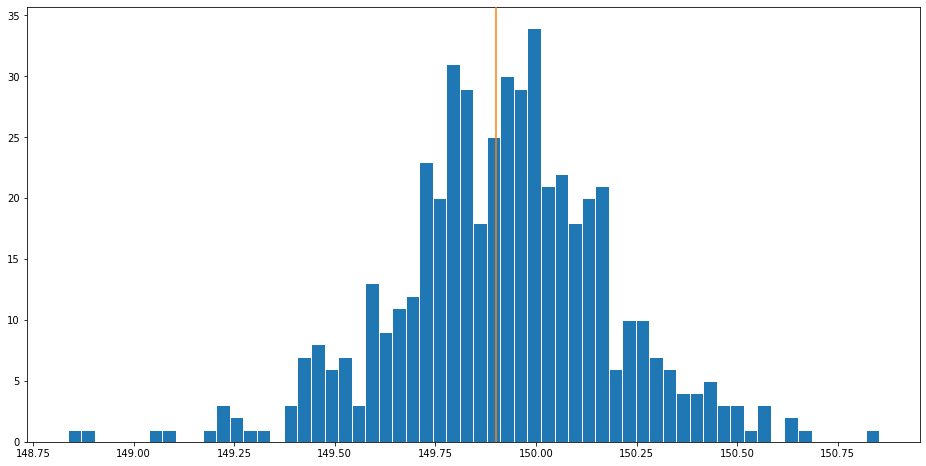

In [11]:
resultsDirty = np.sort(resultsDirty)
#resultsClean = np.sort(resultsClean)

# Histogramm
# Setup the graph
fig_values = plt.figure(figsize=(16,8))
ax = fig_values.gca()
#bx = ax.twinx()

colorHist = 'tab:blue'
colorCurrent = 'tab:orange'
#ax.plot(valDates, resultsDirtyFCB, '.', label = 'Dirty Price', color = colorPrice, zorder = 20)
ax.hist(resultsDirty, bins=60, label = 'Dirty Price', color = colorHist, zorder = 20, edgecolor='w')
ax.axvline(x=currentPriceDirty, ymin=0, ymax=1, color=colorCurrent, zorder = 30)

plt.show()


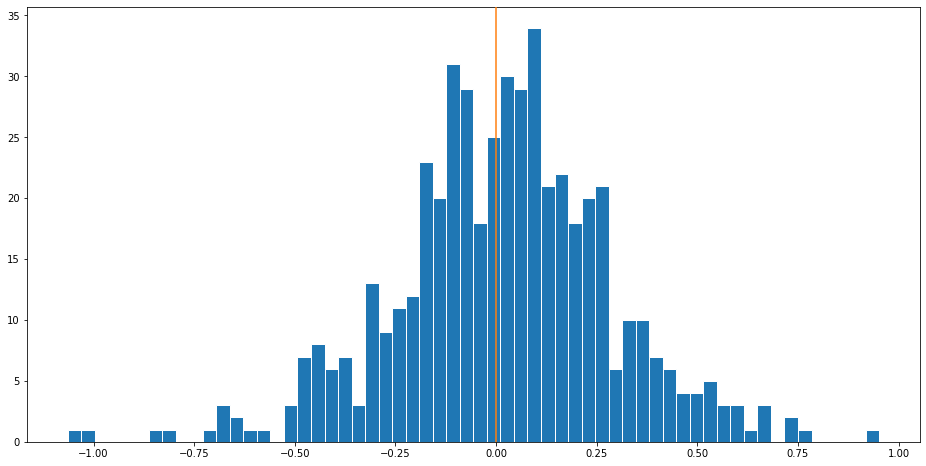

In [12]:
# Histogramm of the changes/differences in value
valDiffsDirty = resultsDirty - currentPriceDirty
fig_diff = plt.figure(figsize=(16,8))
ax = fig_diff.gca()
#bx = ax.twinx()

colorHist = 'tab:blue'
colorCurrent = 'tab:orange'
#ax.plot(valDates, resultsDirtyFCB, '.', label = 'Dirty Price', color = colorPrice, zorder = 20)
ax.hist(valDiffsDirty, bins=60, label = 'Dirty Price', color = colorHist, zorder = 20, edgecolor='w')
ax.axvline(x=0, ymin=0, ymax=1, color=colorCurrent, zorder = 30)

plt.show()

# Compute Value at Risk

In [13]:
valDiffsDirty = -np.sort(-valDiffsDirty)
quantile = 0.99
#print(np.quantile(valDiffsDirty, 1-quantile, interpolation='higher')) # apparently always uses ascending order

# Compute the number of the entry corresponding to the quantile defined above
quantileIndex = np.ceil(len(valDiffsDirty)*quantile).astype(int)
#print(quantileIndex)
#print(quantile * len(valDiffsDirty))

# To get the index of this entry, we have to subtract 1
quantileIndex -= 1

print('With a probability of ' + ((quantileIndex + 1)/len(valDiffsDirty)*100).astype('str') + '%')
print('the value of our portfolio is not going to shrink by more than ' + (-1 * valDiffsDirty[quantileIndex]).astype('str'))
print('in the next ' + str(timeinterval) + ' day(s)')

# Check correctness
#print('--------------')
#print(valDiffsDirty[quantileIndex-1])
#print((quantileIndex)/len(valDiffsDirty))
#print('--------------')
#print(valDiffsDirty[quantileIndex])
#print((quantileIndex + 1)/len(valDiffsDirty))
#print('--------------')
#print(valDiffsDirty[quantileIndex+1])
#print((quantileIndex + 2)/len(valDiffsDirty))
#print('--------------')


With a probability of 99.19678714859438%
the value of our portfolio is not going to shrink by more than 0.7220727813180474
in the next 1 day(s)
